# Molecular Stethoscope Team 2 - Cell-Free mRNA Data Exploration

**Authors: Ruilin, Ju Na, Kendalyn, Haarika**

## Goals: 
- Determine uncertainty standard deviation in the raw RNA-seq data from Molecular Stethoscope
- Compare uncertainty standard deviation in AD vs NCI control group
- Comment on the outcome and visualize results

# 1. Data Import

We imported the raw data from the Excel sheets provided by Molecular Stethoscope. The data was cleaned and organised with appropriate labeling for rows and columns.  

In [43]:
library(readxl) 
library(matrixStats)

We import the data from the Excel sheets to read through the raw data. Correct file path should be used to import. 

In [44]:
sheet1 <- read_xlsx("../../data-s23/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet=1)
sheet2 <- read_xlsx("../../data-s23/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet=2)

We observed some patient IDs have two runs, we will take the average for now and consider standard deviation between patients (biological variation).

In [45]:
data <- sheet2[, 2:339]  ## Taking only columns with patient data, excluded first column and last 6 columns of statistics

In [46]:
names(data) = gsub("-r1|-r2", "", names(data)) ## Cleaning column and row names 

In [47]:
nms <- unique(names(data)) ## Eliminating duplicates 

In [48]:
data <- sapply(nms, function(x) rowMeans(data[names(data) %in% as.numeric(x)])) ## Converting the data into a numeric vector dataframe and taking average of values for patients with two runs

In [49]:
names(data) <- as.character(colnames(data)) ## Converting column names to character vectors

# 2. Determine standard deviation among AD and NCI patient groups

## 2.1 Identifying AD & NCI patient IDs & parse into two data frames

AD and NCI patient data is identified and saved with their respective genes as dataframes.

In [50]:
names(sheet1) <- c('ID', 'Disease') ## Identifying columns names 

AD_id <- na.omit(sheet1$ID[sheet1$Disease == 'AD']) ## Removing 'NA' from the data and seperating AD and NCI patients
NCI_id <- na.omit(sheet1$ID[sheet1$Disease == 'NCI']) 

In [51]:
AD_data <- data[,as.character(AD_id)] ## Creating AD genes and patients dataframe

In [52]:
NCI_data <- data[,as.character(c(NCI_id[1:55], NCI_id[57:116]))] ## Creating NCI genes and patients dataframe, patient no.56 has no entry

## 2.2 Calculating AD & NCI standard deviations

Standard Deviation (SD) is calculated for each gene across all patients for the entire data and both the analytes individually. The resulting data is added as a new column to the current dataframes. 

In [53]:
row_SD <- apply(AD_data, 1, sd) ## Calculating SD row wise for AD genes
AD_data <- cbind(AD_data, raw_SD = row_SD) ## adding new column for SD  

In [54]:
row_SD <- apply(NCI_data, 1, sd) ## Calculating SD row wise for NCI genes
NCI_data <- cbind(NCI_data, raw_SD = row_SD) 

In [55]:
row_SD <- apply(data, 1, sd) ## Calculating SD row wise for all genes  
data <- cbind(data, raw_SD = row_SD)

# 3. Visualizing standard deviation of AD & NCI patients' data

### Two main visualization methods are implemented in this section:
- Histogram of standard deviations
- Scatterplot of TPM counts against STDEV

## 3.1 Histogram of standard deviations

In [56]:
{echo=FALSE}

library(ggplot2)
library(dplyr)
library(viridis)

We had to take out some columns for standard deviation calculations. Now putting `gene_id` and `description` back.

In [57]:
data <- cbind(data, gene=sheet2[,1], description=sheet2[,340])
AD_data <- cbind(AD_data, gene=sheet2[,1], description=sheet2[,340])
NCI_data <- cbind(NCI_data, gene=sheet2[,1], description=sheet2[,340])

In [58]:
data <- filter(data, !startsWith(gene_id, "ERCC"))
AD_data <- filter(AD_data, !startsWith(gene_id, "ERCC"))
NCI_data <- filter(NCI_data, !startsWith(gene_id, "ERCC"))

If you run the above cells more than once, use `data <- subset(data, select= -gene_id)` to get rid of duplicate columns.         

In [59]:
sum(startsWith(data$gene, "ERCC"))
## There are 92 rows for ERCC genes, so we removed them

[1] 0

`sorted_` things do not contain ERCC standards and are sorted by decreasing SD

In [60]:
sorted_data <- arrange(data, -raw_SD) #order genes by decreasing SD
sorted_AD_data <- arrange(AD_data, -raw_SD)
sorted_NCI_data <- arrange(NCI_data, -raw_SD)

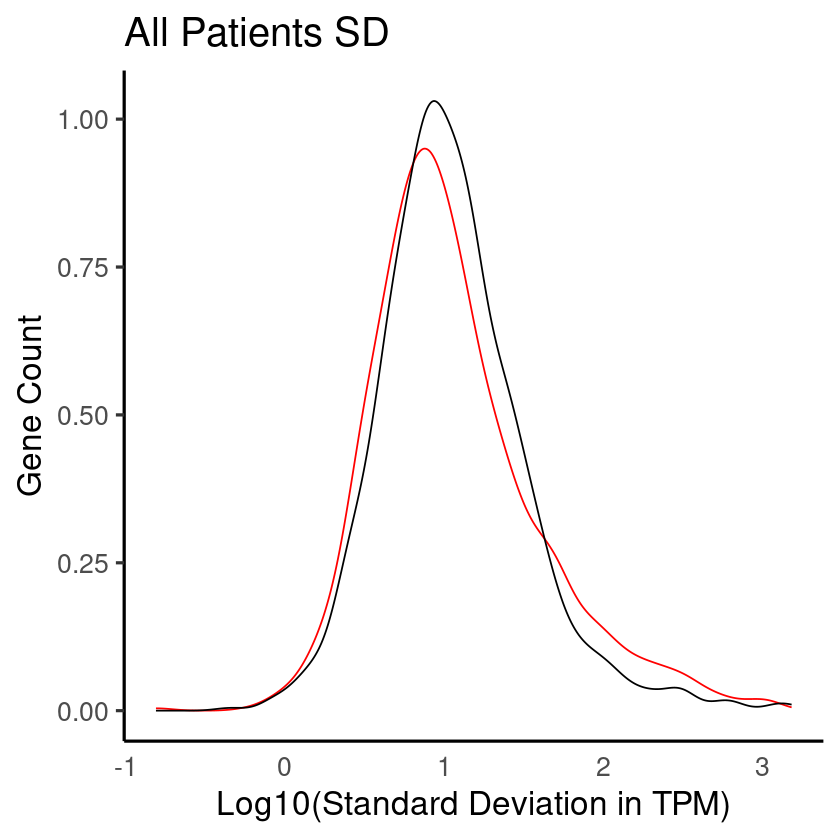

In [61]:
ggplot() +
  geom_density(data = sorted_AD_data, 
                 aes(x = log10(raw_SD)), 
                 color = "red") +
  geom_density(data = sorted_NCI_data, 
                 aes(x = log10(raw_SD)), 
                color = "black") +
  theme_classic(base_size = 20) +
  ylab("Gene Count") + 
  xlab("Log10(Standard Deviation in TPM)") + 
  ggtitle("All Patients SD") +
  theme(axis.ticks.x=element_blank(), legend.position = "none")

In [62]:
ggsave(file = "./plots/logSD_AD_vs_NCI.png", device="png")

Saving 6.67 x 6.67 in image


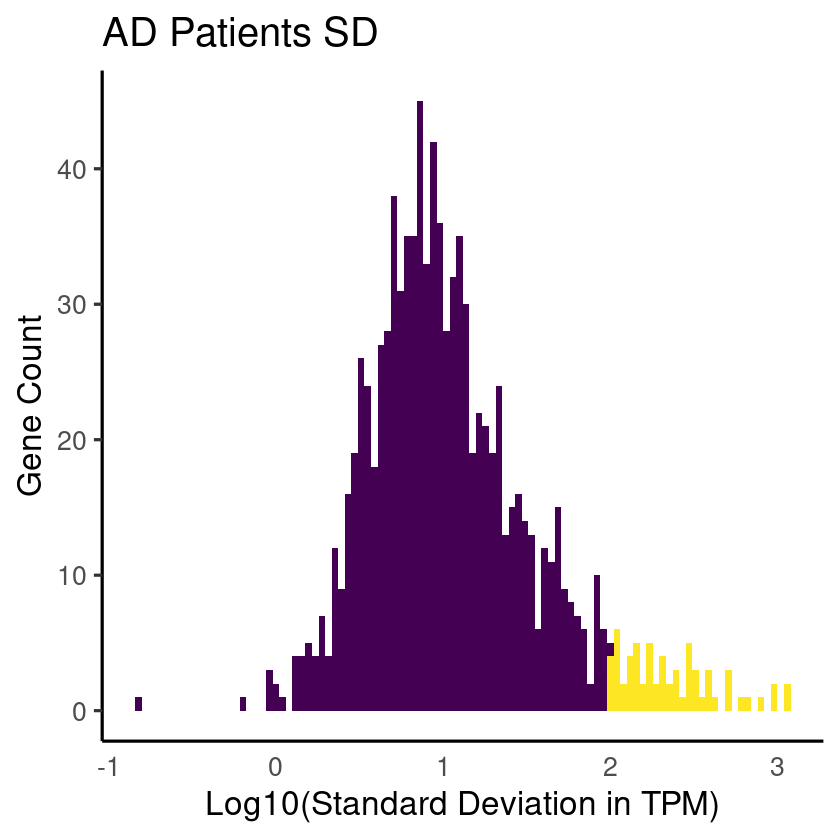

In [63]:
sorted_AD_data %>%
  mutate(large_SD = (raw_SD > 100))  %>%
  ggplot() +
  geom_histogram(aes(x = log10(raw_SD), fill = large_SD), bins = 100) + 
  scale_fill_viridis(discrete = TRUE, option = "D") + 
  theme_classic(base_size = 20) +
  ylab("Gene Count") + 
  xlab("Log10(Standard Deviation in TPM)") + 
  ggtitle("AD Patients SD") +
  theme(axis.ticks.x=element_blank(), legend.position = "none")

# Genes with SD>100 are shown in yellow

In [64]:
ggsave(file = "./plots/AD_logSD.png", device="png")

Saving 6.67 x 6.67 in image


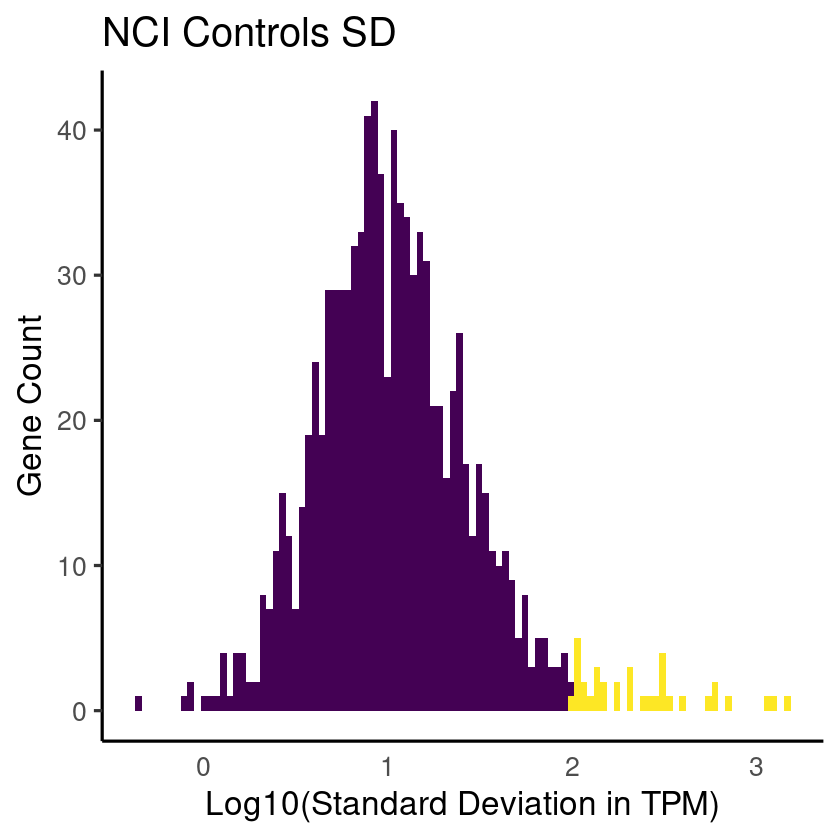

In [65]:
sorted_NCI_data %>%
  mutate(large_SD = (raw_SD > 100))  %>%
  ggplot() +
  geom_histogram(aes(x = log10(raw_SD), fill = large_SD), bins = 100) + 
  scale_fill_viridis(discrete = TRUE, option = "D") + 
  theme_classic(base_size = 20) +
  ylab("Gene Count") + 
  xlab("Log10(Standard Deviation in TPM)") + 
  ggtitle("NCI Controls SD") +
  theme(axis.ticks.x=element_blank(), legend.position = "none")

# Genes with SD>100 are shown in yellow

In [66]:
ggsave(file = "./plots/NCI_logSD.png", device="png")

Saving 6.67 x 6.67 in image


## 3.2 Plot of TPM vs Standard Deviation

In [67]:
AD_data$mean <- rowMeans(AD_data[,1:127])
NCI_data$mean <- rowMeans(NCI_data[,1:115])
data$mean <- rowMeans(data[,1:243])

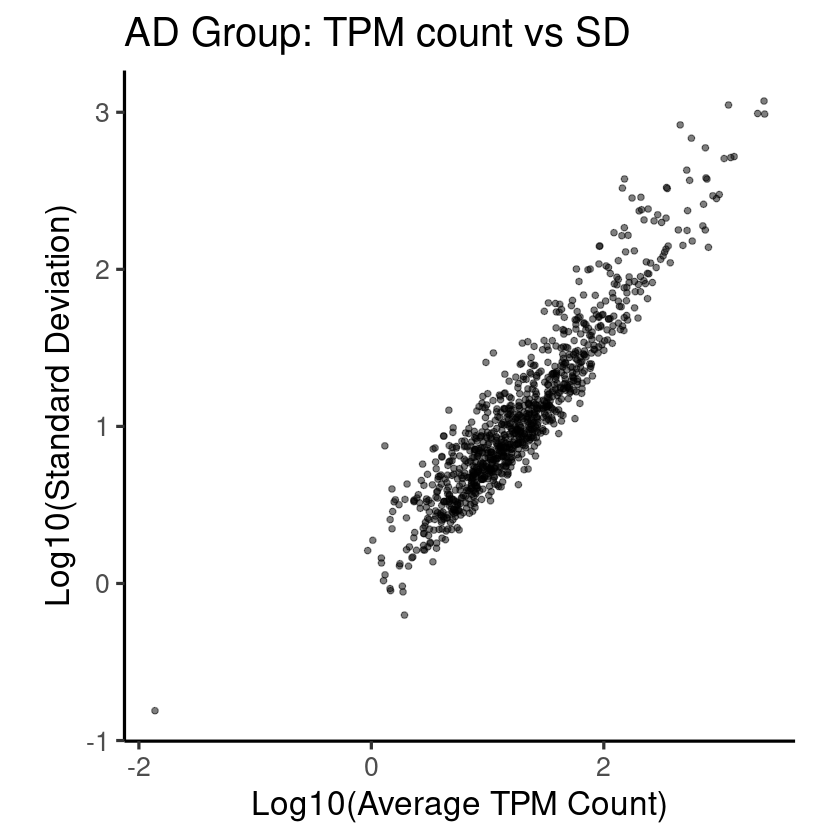

In [72]:
AD_data %>%
  ggplot(aes(x = log10(mean), y = log10(raw_SD))) +
  geom_point(alpha = 0.5) +
  xlab("Log10(Average TPM Count)") +
  ylab("Log10(Standard Deviation)") +
  ggtitle("AD Group: TPM count vs SD") +
  theme_classic(base_size = 20) +
  theme(aspect.ratio = 1)

In [73]:
ggsave("./plots/AD_TPM_vs_SD.png", device = "png", scale = 1)

Saving 6.67 x 6.67 in image


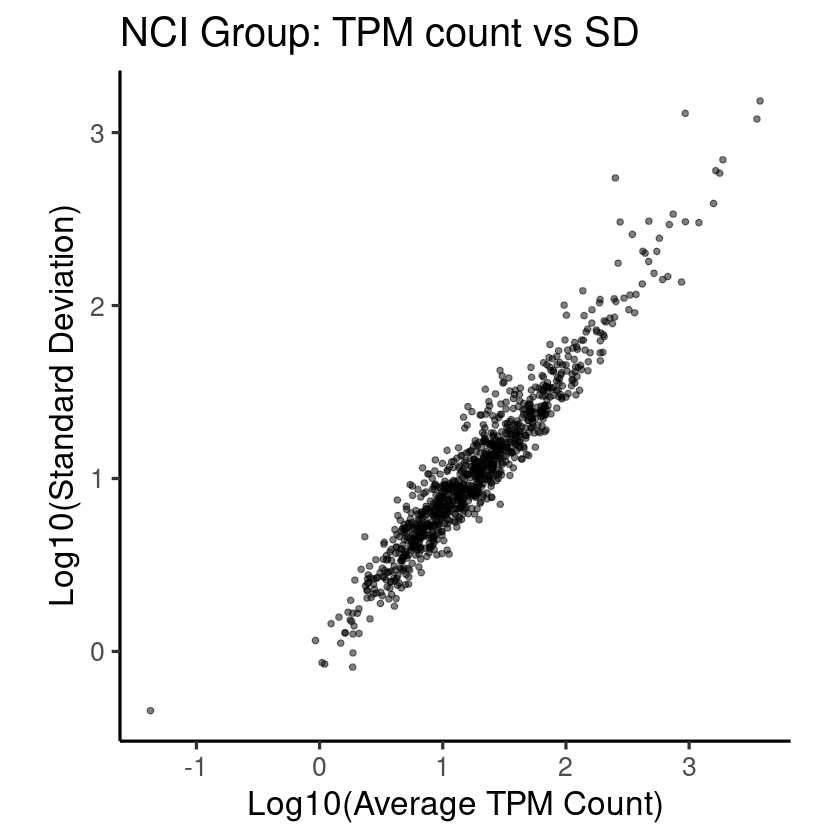

In [76]:
NCI_data %>%
  ggplot(aes(x = log10(mean), y = log10(raw_SD))) +
  geom_point(alpha = 0.5) +
  xlab("Log10(Average TPM Count)") +
  ylab("Log10(Standard Deviation)") +
  ggtitle("NCI Group: TPM count vs SD") +
  theme_classic(base_size = 20)  +
  theme(aspect.ratio = 1)

In [77]:
ggsave("./plots/NCI_TPM_vs_SD.png", device = "png", scale = 1)

Saving 6.67 x 6.67 in image


# 4 Save Results

In [81]:
write.csv(AD_data, "./tables/AD_data.csv")
write.csv(NCI_data, "./tables/NCI_data.csv")
write.csv(data, "./tables/data.csv")